In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import datasets
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LinearRegression

sys.path.append("..")
import src

primary, accent = src.theme.set()
pal = sns.color_palette("wfondrie")

def save(fname):
    """Save the figures"""
    figures = Path("figures")
    figures.mkdir(exist_ok=True)
    if not fname.startswith("01_"):
        fname = "06_" + fname
        
    if not fname.endswith(".png"):
        fname += ".png"
    
    plt.tight_layout(pad=0.2)
    plt.savefig(figures / fname, dpi=300)

## Hyperplanes

/var/folders/8x/xhjqq1ss58jcyc89wf32hc0c0000gn/T/ipykernel_92782/2689598266.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=0.2)


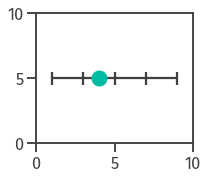

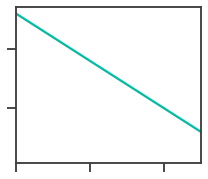

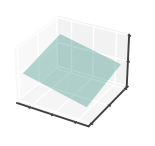

In [2]:
# set up the figure
fig = plt.figure(figsize=(2.75, 2.35))
ax = fig.add_subplot(111)
ax.set_xlim(0,10)
ax.set_ylim(0,10)

# draw lines
xmin = 1
xmax = 9
y = 5
height = 1

plt.hlines(y, xmin, xmax, color=primary)
for x in np.linspace(xmin, xmax, 5):
    plt.vlines(x, y - height / 2., y + height / 2., color=primary)

# draw a point on the line
px = 4
plt.plot(px,y, 'o', ms = 15)
save("1d")

plt.figure(figsize=(2.75, 2.35))
x = np.linspace(0, 3)
func = lambda x: -4*x + 8
plt.plot(x, func(x))
plt.xlim(0, 2.5)
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
save("2d")

# plot the surface
fig, ax = plt.subplots(figsize=(2.75, 2.35), subplot_kw={"projection": "3d"})
X = np.arange(-5, 5, 0.25) * 0.7
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = -1.6*X + 0.8*Y

ax.plot_surface(
    X, 
    Y, 
    Z, 
    alpha=0.3,
    linewidth=0, 
    antialiased=True,
)

ax.set_zlim(-20, 20)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

save("3d")

## Which hyperplane

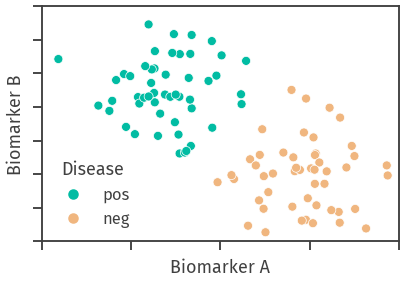

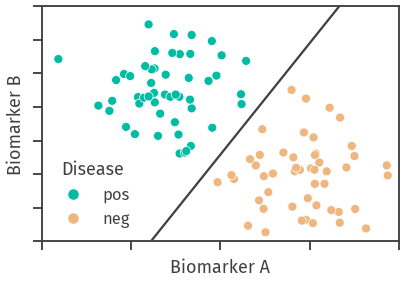

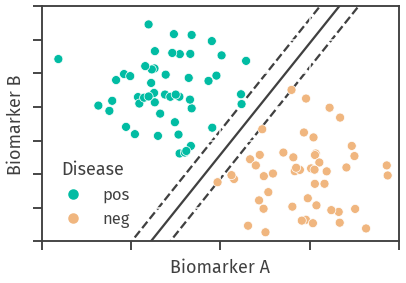

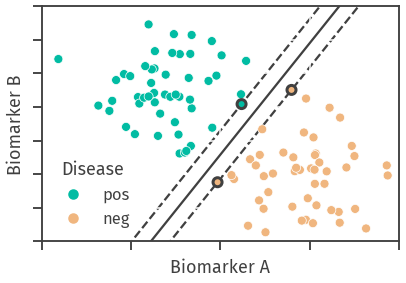

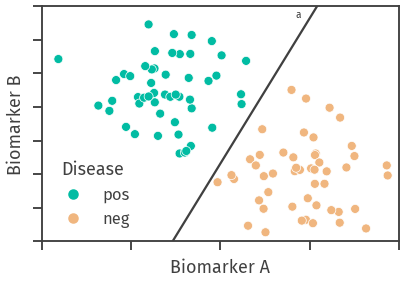

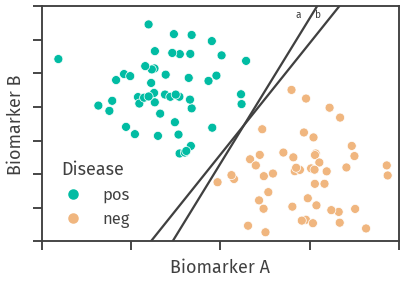

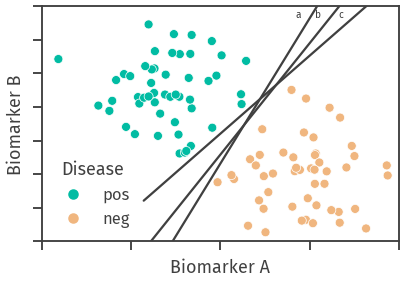

In [3]:
def fig_base(figsize=(5.5, 3.8), cluster_std=2.5):
    plt.figure(figsize=figsize)
    X, y = datasets.make_blobs(
        n_features=2, 
        centers=2,
        random_state=42,
        cluster_std=cluster_std,
    )
    
    y = pd.Series(y).replace({0: "pos", 1:"neg"})
    
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
    plt.legend(title="Disease", loc="lower left")
    plt.xlabel("Biomarker A")
    plt.ylabel("Biomarker B")
    plt.xlim(-10, 10)
    plt.ylim(-2.5, 15)
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    return plt.gca(), X, y


# Base Figure:
_, X, y = fig_base()
save("max_margin_0")

# With hyperplane:
fig_base()
clf = SVC(C=1000000, kernel="linear").fit(X, y)
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-10, 10)
yy = a * xx - (clf.intercept_[0]) / w[1]
plt.plot(xx, yy, color=primary)
save("max_margin_2")

# With hyperplane and margin:
margin = 1 / np.sqrt(np.sum(clf.coef_**2))
yy_down = yy - np.sqrt(1 + a**2) * margin
yy_up = yy + np.sqrt(1 + a**2) * margin
fig_base()
plt.plot(xx, yy, color=primary)
plt.plot(xx, yy_down, c=primary, linestyle="dashed", zorder=0)
plt.plot(xx, yy_up, c=primary, linestyle="dashed", zorder=0)
save("max_margin_3")

# With hyperplane + margin + support vectors:
fig_base()
plt.plot(xx, yy, color=primary)
plt.plot(xx, yy_down, c=primary, linestyle="dashed", zorder=0)
plt.plot(xx, yy_up, c=primary, linestyle="dashed", zorder=0)
sv = clf.support_vectors_
sns.scatterplot(x=sv[:, 0], y=sv[:, 1], color="None", edgecolor=primary, linewidth=3)
plt.legend(title="Disease", loc="lower left")
save("max_margin_4")

# Random lines:
lr1 = LinearRegression().fit(sv[1:, [0]], sv[1:, 1])
lr2 = LinearRegression().fit(sv[:2, [0]], sv[:2, 1])
line1 = lr1.predict(xx[:, None]) * 0.5 + 2
line2 = lr2.predict(xx[14:, None]) * 0.7 + 4

def add_line1():
    plt.plot(xx, line1, color=primary)
    plt.annotate("a", (0.71, 0.99), xycoords="axes fraction", va="top")
    
def add_line2():
    plt.plot(xx[14:], line2, color=primary)
    plt.annotate("c", (0.83, 0.99), xycoords="axes fraction", va="top")
    

fig_base()
add_line1()
save("max_margin_1a")

fig_base()
add_line1()
plt.plot(xx, yy, color=primary)
plt.annotate("b", (0.765, 0.99), xycoords="axes fraction", va="top")
save("max_margin_1b")

fig_base()
add_line1()
plt.plot(xx, yy, color=primary)
plt.annotate("b", (0.765, 0.99), xycoords="axes fraction", va="top")
add_line2()
save("max_margin_1c")

## MMC to SVM

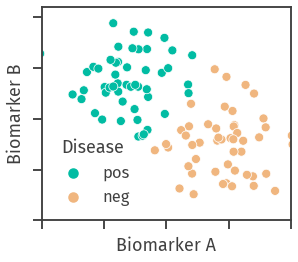

In [4]:
_, X, y = fig_base((4, 3.5), cluster_std=2.9)
plt.ylim(-5, 16)
save("not-separable")

## hinge loss

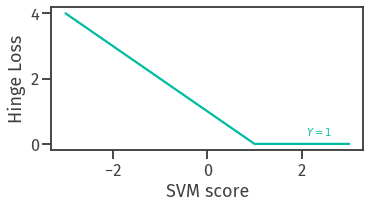

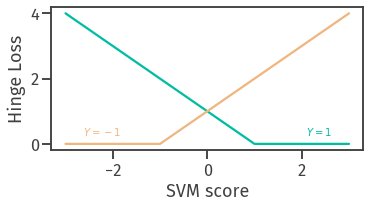

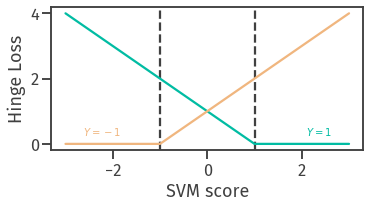

In [5]:
def hinge_loss(x, label=1):
    y = 1 - label*x
    y[ y < 0] = 0
    return  y


x = np.arange(-3, 4)
y1 = hinge_loss(x, 1)
y2 = hinge_loss(x, -1)

# y = 1
plt.figure(figsize=(5, 2.75))
plt.plot(x, y1, label="$Y = 1$")
plt.annotate("$Y = 1$", (0.9, 0.1), xycoords="axes fraction", color=pal[0], ha="right")
plt.xlabel("SVM score")
plt.ylabel("Hinge Loss")
save("hinge_0")

# both
plt.figure(figsize=(5, 2.75))
plt.plot(x, y1, label="$Y = 1$")
plt.plot(x, y2, label="$Y = -1$")
plt.annotate("$Y = 1$", (0.9, 0.1), xycoords="axes fraction", color=pal[0], ha="right")
plt.annotate("$Y = -1$", (0.1, 0.1), xycoords="axes fraction", color=pal[1])
plt.xlabel("SVM score")
plt.ylabel("Hinge Loss")
save("hinge_1")

# both + margins
plt.figure(figsize=(5, 2.75))
plt.axvline(1, color=primary, linestyle="dashed")
plt.axvline(-1, color=primary, linestyle="dashed")
plt.plot(x, y1, label="$Y = 1$")
plt.plot(x, y2, label="$Y = -1$")
plt.annotate("$Y = 1$", (0.9, 0.1), xycoords="axes fraction", color=pal[0], ha="right")
plt.annotate("$Y = -1$", (0.1, 0.1), xycoords="axes fraction", color=pal[1])
plt.xlabel("SVM score")
plt.ylabel("Hinge Loss")
save("hinge_2")


## Hinge vs log loss

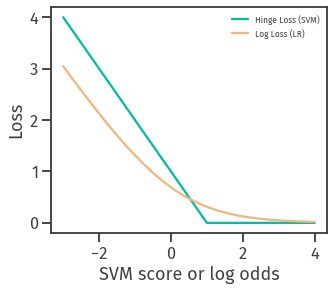

In [6]:
def logloss(x, y=1):
    px = np.exp(x) / (1 + np.exp(x))
    return -(y*np.log(px) + (1-y)*np.log(1-px))

x = np.linspace(-3, 4)
y1 = hinge_loss(x, 1)
y2 = logloss(x, 1)

# y = 1
plt.figure(figsize=(4.5, 3.9))
plt.plot(x, y1, label="Hinge Loss (SVM)")
plt.plot(x, y2, label="Log Loss (LR)")
plt.legend(fontsize="small")
plt.xlabel("SVM score or log odds")
plt.ylabel("Loss")
save("hinge_vs_logloss")

## Kernel trick

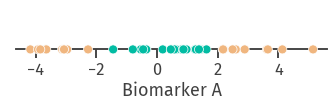

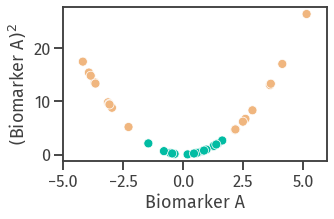

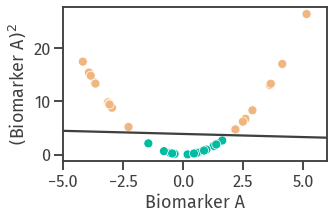

In [7]:
from matplotlib import ticker

rng = np.random.default_rng(42)
pos = pd.DataFrame({
    "x": rng.normal(0, 1, 20) + 0.5,
    "y": "pos",
    "lab": 1,
})

neglo = pd.DataFrame({
    "x": rng.normal(0, 1, 10) - 3.5,
    "y": "neg",
    "lab": 0,
})

neghi = pd.DataFrame({
    "x": rng.normal(0, 1, 10) + 3,
    "y": "neg",
    "lab": 0,
})

data = pd.concat([pos, neglo, neghi])

fig, ax = plt.subplots(figsize=(4.5, 1.4))
ax.spines["right"].set_color("none")
ax.spines['left'].set_color("none")
ax.yaxis.set_major_locator(ticker.NullLocator())
ax.spines['top'].set_color("none")
ax.spines["bottom"].set_position("zero")
sns.scatterplot(data=data, x="x", y=0, hue="y", zorder=1000)
ax.legend("")
ax.set_xlabel("Biomarker A")
save("kernel_trick0")

plt.figure(figsize=(4.5, 2.9))
data["x2"] = data["x"]**2
sns.scatterplot(data=data, x="x", y="x2", hue="y")
plt.legend("")
plt.xlabel("Biomarker A")
plt.ylabel("$(\\mathregular{Biomarker~A})^2$")
plt.xlim(-5, 6)
save("kernel_trick1")

plt.figure(figsize=(4.5, 2.9))
data["x2"] = data["x"]**2
sns.scatterplot(data=data, x="x", y="x2", hue="y")
plt.legend("")
plt.xlabel("Biomarker A")
plt.ylabel("$(\\mathregular{Biomarker~A})^2$")
plt.xlim(-5, 6)

clf = SVC(kernel="linear").fit(data.loc[:, ["x", "x2"]].to_numpy(), data["lab"].to_numpy()) 
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-10, 10)
yy = a * xx - (clf.intercept_[0]) / w[1]
plt.plot(xx, yy, color=primary)
save("kernel_trick2")

## Non linear example

ValueError: could not convert string to float: 'pos'

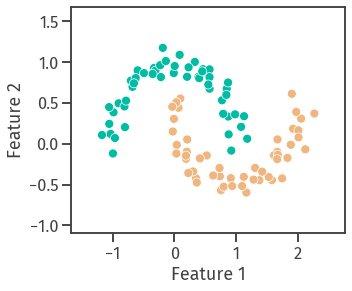

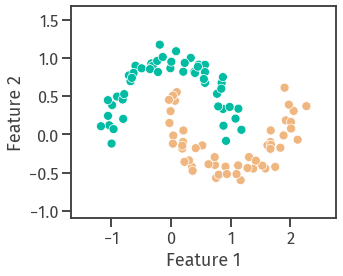

In [8]:
def plot_contours(clf, X, ax=None):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.01),
        np.arange(y_min, y_max, 0.01),
    )
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    if ax is None:
        ax = plt.gca()
        
    out = ax.contour(xx, yy, Z, colors=primary)
    return out


def moons(figsize=(4.75, 3.9)):
    X, y = datasets.make_moons(
        noise=0.1,
        random_state=42
    )

    plt.figure(figsize=figsize)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
    plt.legend("")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
    plt.ylim(X[:, 1].min() - 0.5, X[:,1].max() + 0.5)
    return X, y


moons()
save("moons_0")

lin = SVC(kernel="linear").fit(X, y)
rbf = SVC(kernel="rbf").fit(X, y)

moons()
plot_contours(lin, X)
save("moons_1")

moons()
plot_contours(rbf, X)
save("moons_2")

## Scaling

In [ ]:
x = np.linspace(0,3)
t1 = x**2
t2 = x**3

plt.figure(figsize=(4.8, 3.7))
plt.plot(x, t1, label="$O(n_{features} \\times n_{examples}^2)$")
plt.plot(x, t2, label="$O(n_{features} \\times n_{examples}^3)$")
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.xlabel("# of Examples")
plt.ylabel("Execution Time")
plt.legend()
save("scaling")

# Cost Parameter

In [ ]:
from sklearn import metrics

X_train, y_train = datasets.make_blobs(
        n_features=2, 
        centers=2,
        random_state=42,
        cluster_std=5,
    )

X_test, y_test = datasets.make_blobs(
        n_features=2, 
        centers=2,
        random_state=42,
        cluster_std=5,
    )



for c in [0.001, 0.01, 0.1, 1, 10]:
    plt.figure()
    sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train)
    plt.legend("")
    
    clf = SVC(C=c, kernel="linear").fit(X_train, y_train)
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-10, 10)
    yy = a * xx - (clf.intercept_[0]) / w[1]
    margin = 1 / np.sqrt(np.sum(clf.coef_**2))
    yy_down = yy - np.sqrt(1 + a**2) * margin
    yy_up = yy + np.sqrt(1 + a**2) * margin
    plt.plot(xx, yy, color=primary)
    plt.plot(xx, yy_down, color=primary, linestyle="dashed")
    plt.plot(xx, yy_up, color=primary, linestyle="dashed")
    